# Data Analysis of Popular Videos on Bilibili

**Since this project started as a side project of mine, I never worried about none-Chinese speakers readingit. Therefore I chose to analyze video info of a Chinese platform, so some part of this tutorial will contain Chinese content from the website. ALL RELEVANT CONTENT IN CHINESE WILL BE TRANSLATED TO ENGLISH TO THE BEST OF MY KNOWLEDGE. To the course staff, it might be better to have a TA that speaks Chinese grade this tutorial, solely for the purpose of reducing confusion. To the student grader reading this, I'm sorry for any confusion that I may have caused due to language. **

## Introduction
Bilibili (bilibili.com) is a popular Chinese video platform. Bilibili allows users to post "bullet comments", comments that flow across the screen during playback. Bilibili attracts a lot of user and creators that are fans of the ACG (Anime, Comics, Game) subculture. Apart from these topics, there are also creators that create parody videos, vlogs, various tutorials, and videos of other themes. 

In this tutorial, we will be discussing some techniques learned in 15-688 to gather and analyze trending videos on Bilibili. 

For the data crawling part of this tutorial, the following packages are all we need.

In [190]:
import requests
import json
import pandas as pd
import numpy as np

To crawl data from the website, we first need to find what APIs the website makes availabe to us. One common method is to look at the source code of the pages we wish to gather data from to see what kind of requests it send back to the server, and what kind of data the server sends back. We could then send the same requests with our code and process the data the server sends back.

For this tutorial, we will look at vlogs (video logs) under the "Daily life" (日常) category (this project started because I know someone who makes vlogs on Bilibili and we were interested in what kind of vlogs are popular, therefore we're looking at vlogs). We will also rank the videos by popularity. To do this, we will go to Bilibili and select the corresponding categories. We also need to have the developer tools in our browser, Chrome in this case, so that we could monitor network activities in order to see the requests sent to Bilibili.

<figure>
    <img src='1.png' >
    <figcaption><b>Selecting the categories from the website front end</b></figcaption>
</figure>

<br>

<figure>
    <img src='2.png' >
    <figcaption><b>What the request to the server looks like</b></figcaption>
</figure>

The actual request made to the server is

https://s.search.bilibili.com/cate/search?callback=jQuery17209714882071747022_1522287247741&main_ver=v3&search_type=video&view_type=hot_rank&order=click&copy_right=-1&cate_id=21&page=1&pagesize=20&jsonp=jsonp&time_from=20180322&time_to=20180329&keyword=vlog&_=1522288034551

The request is made to https://s.search.bilibili.com, which we assume is a searching API to query video data from. The callback is an AJAX related jQuery function which we could ignore when we request through Python. The next few parameters determines what we're searching (search_type), how are we ranking the videos (view_type=hot_rank, we're ranking by popularity here) etc. 

Next, we need to determine what type of data the server sends back. We could directly copy-paste the request into our browser and hit enter, or we could look at the response in the Response tab in our browser tool. We won't show the entire response, since it is very long. As we specified in our API call, the response will contain data for 20 videos (pagesize=20). We could determine that the data type is JSON. Here is an excerpt of data that represents attributes of a video:

    {"badgepay":false,
            "play":"582893",
            "description":too long, omitted,
            "pubdate":"2018-03-05 16:07:29",
            "title":too long, omitted,
            "review":3082,
            "pic":"\/\/i0.hdslb.com\/bfs\/archive\/ed2af0240b8fbd85fced652efa5d0dc1e3b69365.jpg",
            "mid":164139557,
            "id":20401011,
            "arcurl":"http:\/\/www.bilibili.com\/video\/av20401011",
      "tag":"\u751f\u6d3b\u8bb0\u5f55,vlog,\u65e5\u5e38,\u751f\u6d3b,2018,\u641e\u7b11,\u65c5\u884c,\u65b0\u5e74,\u53a6\u95e8,\u6e38\u8bb0",
            "video_review":12338,
            "author":"\u6d3b\u8e66\u4e71\u8df3\u7684\u80a5\u66c8",
            "favorites":5676,
            "duration":2003,
            "type":"video",
            "arcrank":"0",
            "senddate":1520237251},
            
We're not interested in all of the fields here. Bilibili doesn't seem to make their API documentation available to us, therefore we couldn't figure out what "arcrank" and "badgepay" means. However, since the "arcrank" field and the "badgepay" for all 20 videos have the same value, we will omit them here, for now. 

Some of these fields are not as self-explanatory as we expect. The 'mid' field is the user id of the uploader. The 'video_review' field is the number of bullet comments on a video, which are different from normal comments that appear normally at the bottom of the page. Each video can have multiple tags. As the JSON example above shows, they are separated by comma. We will include the video url here as we have the video id, and could simply visit the videos by going to http://bilibili.com/video/av + video id. For upload date, we will use pubdate, as we've verified with what's on the front end of the website. 

Now it's time for us to crawl our data from Bilibili. The url is pretty much what we want. The API divides the result into pages, therefore we need a way to determine how many pages there are, then make several calls to get data from all pages. 

The following piece of code does exactly that. We first make one call to the first page. The result JSON will tell us how many pages there are. Then we loop through all the pages. For the videos on each page, we simply extract the JSON dictionary representing the video and save it to a list. 

In [191]:
videos = []
page = 1
url = 'https://s.search.bilibili.com/cate/search?main_ver=v3&search_type=video&view_type=hot_rank&order=click&copy_right=-1&cate_id=21&pagesize=20&jsonp=jsonp&time_from=20180305&time_to=20180312&keyword=vlog&page=' 
r = requests.get(url+str(page))
response = json.loads(r.text)
num_pages = int(response['numPages'])

In [192]:
for i in range(1, num_pages+1):
    if(i%100 == 0):
        print(i)

    r = requests.get(url+str(i))
    response = json.loads(r.text)
    for video in response['result']:
        #videos.append(Video(**video))
        videos.append(video)

100
200
300
400


Let's print out the first five videos that we received. 

In [200]:
for i in range(5):
    #print(videos[i].__dict__)
    print(videos[i])
    print('\n')

{'badgepay': False, 'play': '651402', 'description': '微博@走向世界的彭美丽', 'pubdate': '2018-02-12 15:58:57', 'title': '上海vlog 穿高领毛衣精蹦的坏女孩们', 'review': 3055, 'pic': '//i0.hdslb.com/bfs/archive/053cde6baeacfd92cfb70db3ee143b146f5df593.jpg', 'mid': 164139557, 'id': 19494744, 'arcurl': 'http://www.bilibili.com/video/av19494744', 'tag': 'vlog,日常,旅游,生活,记录,上海', 'video_review': 9325, 'author': '活蹦乱跳的肥曈', 'favorites': 3893, 'duration': 993, 'type': 'video', 'arcrank': '0', 'senddate': 1518422340}


{'badgepay': False, 'play': '593370', 'description': '快来微博找我玩@走向世界的彭美丽 揪咪', 'pubdate': '2018-03-05 16:07:29', 'title': '厦门过年vlog 超开心的家庭旅行', 'review': 3084, 'pic': '//i0.hdslb.com/bfs/archive/ed2af0240b8fbd85fced652efa5d0dc1e3b69365.jpg', 'mid': 164139557, 'id': 20401011, 'arcurl': 'http://www.bilibili.com/video/av20401011', 'tag': '生活记录,vlog,日常,生活,2018,搞笑,旅行,新年,厦门,游记', 'video_review': 12563, 'author': '活蹦乱跳的肥曈', 'favorites': 5724, 'duration': 2003, 'type': 'video', 'arcrank': '0', 'senddate': 1520237251}




Seems like our code worked as planned. 

Next, let's create a datafrae for our video info. In the following piece of code, we create a data frame with the keys of a video info dictionary as the columns, then dump the information in the dictionaries in to the data frame. Then we convert the data types of certain columns to appropriate data types. Finally we sort the data frame in descending order of the views each video has, then we remove any potential duplicate entries and columns that we don't want.

In [201]:
# video_df = pd.DataFrame(columns=videos[0].__dict__.keys())
video_df = pd.DataFrame(columns=videos[0].keys())
for video in videos:
    # video_df = video_df.append(video.__dict__, ignore_index=True)
    video_df = video_df.append(video, ignore_index=True)

video_df['play'] = video_df.play.astype(int)
video_df['pubdate'] = pd.to_datetime(video_df.pubdate)
video_df['review'] = video_df.review.astype(int)
video_df['mid'] = video_df.mid.astype(int)
video_df['video_review'] = video_df.video_review.astype(int)
video_df['favorites'] = video_df.favorites.astype(int)
video_df['duration'] = video_df.duration.astype(int)
video_df['id'] = video_df.id.astype(int)

video_df = video_df.sort_values(by=['play'], ascending=[0])
video_df = video_df.drop_duplicates(['id'])
video_df = video_df.drop(['badgepay', 'pic', 'arcurl', 'arcrank', 'senddate'], axis=1)

print(video_df.head())

     play                                        description  \
0  651402                                        微博@走向世界的彭美丽   
1  593370                                快来微博找我玩@走向世界的彭美丽 揪咪   
2  591852  第一次啊第一次，大家轻点，偷偷的！！观众大人们点个关注吧！转自http://opdwz.cn...   
3  253139  谢谢观看～\n新浪微博：http://weibo.com/JJsays\nInstagram...   
4  184840                               美国小姐姐星悦的秋叶原Cosplay之旅   

              pubdate                                       title  review  \
0 2018-02-12 15:58:57                         上海vlog 穿高领毛衣精蹦的坏女孩们    3055   
1 2018-03-05 16:07:29                           厦门过年vlog 超开心的家庭旅行    3084   
2 2018-02-13 06:15:01  拥有一个日本的妹子是怎样的体验？（这个视频不好看，大家都别看，我偷偷看就行了!!!）     921   
3 2018-02-13 11:15:57                               美国女生对超显腿细的反应～    1205   
4 2018-02-23 21:33:53                        美国小姐姐星悦的秋叶原Cosplay之旅     959   

         mid        id                                                tag  \
0  164139557  19494744                                vlog,日常,旅游,生活,记录,上海  

Next, let's import and configure matplotlib to be used in jupyter notebook.

In [202]:
## [1] Taken from the handout code from previous assignments
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in l

The first thing we're interested in is the distribution of views among the videos. Based on experience with video sites, we observed that despite the number of videos and creators on a given platform, there will only be a handful of creators or videos that really attract a lot of traffic. We therefore have a hypothesis that the number of views each video get vs the number of videos loosely follows the Zipf's law, that is, only a small percentage of videos get a lot of views, while most videos won't get too many views. Since we've already ranked our videos by view, let's make graph to find out.

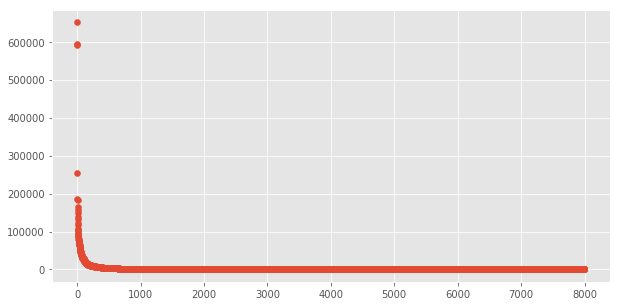

In [203]:
view_graph = plt.scatter([i+1 for i in range(len(video_df))], video_df['play'])
plt.show()
# print(np.mean(video_df['play'][75:100]))


It looks like the graph loosly follows that of a Zipf's distribution. We could also plot a log-log graph to find out.

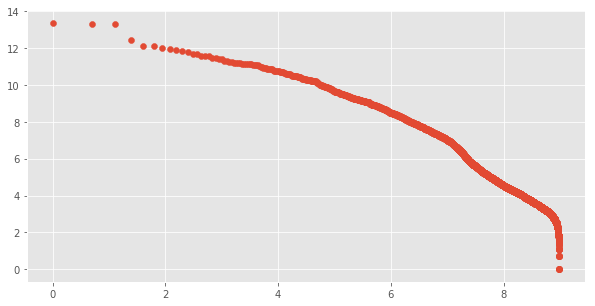

In [204]:
view_graph = plt.scatter([np.log(i+1)for i in range(len(video_df))], [np.log(play) for play in video_df['play']])
plt.show()

We got a curve that very loosely resembles a log-log line on a Zipf's distribution, if we take away the tail. But still, only a small number of videos attract the most views. 

Next, let's find out which tags are the most popular, since tags are clearly defined themes that are separated by commas, making it easier to process and understand. I made two ways to rank popular tags, by count, or by weight , the weight the log of the rank it belongs. E.g., the weight of tags on the first video out of 5000 would be np.log(5000). The idea is to give tags appearing in popular videos a higher score.

We have developed a function that would take in a list of list of words, a number n, and a boolean variable indicating how we want to score the words. For example:
```python
top_n_words([['hello', 'world'], ['hello', 'there'], ['hello', 'goodbye']], 2, True)
```
will score the words in the first two lists by counting their appearences. The reason why we are doing a list of lists of words is because we want to keep the order of the tags, as well as separating the tags by video. 

In [205]:
from collections import Counter

def top_n_words(lines, n, count):
    result = {}
    lines = lines[:n] if len(lines) > n else lines
    i = n+1
    for line in lines:
        for word in line:#video_df['tag'][:n]:
            word = word.lower()
            if word not in result:
                result[word] = 0
            result[word] += 1 if count else np.log(i)
        i -= 1

    words_sorted = sorted(result, key=result.get, reverse=True)
    word_count = [result[word] for word in words_sorted]
    return dict(zip(words_sorted, word_count))



Let's take a look at the top 100 tags among the top 5000 videos, both by weight and count.

In [206]:
tags = [tag.split(',') for tag in video_df['tag']]
top_100_count = list(top_n_words(tags, 5000, True).keys())[:100]
top_100_weight = list(top_n_words(tags, 5000, False).keys())[:100]

overlap = [tag for tag in top_100_count if tag in top_100_weight]
print(overlap)

print([tag for tag in top_100_count if tag not in top_100_weight])

['vlog', '日常', '生活记录', '旅行', '自制', '旅游', '生活', 'youtube', '摄影', '学习', '记录', '游记', '美食', '分享', '搬运', '搞笑', '校园', '日本', '留学', 'study with me', '美国', '欧美', '上海', '原创', '同性', '英国', '春节', '萌妹子', '美食圈', 'gay', '韩国', 'gopro', '香港', '减肥', '广州', '油管', '帅哥', '泰国', '过年', '留学生', '夫夫', '吃货', '情侣', '大学', '高能', '中国', 'study', '开箱', '美女', 'study account', '歪果仁', '英语', '文化', '新年', '东京', '北京', '考研', '成都', '运动', '手帐', '购物分享', '加拿大', '台湾', '吃播', '粤语', '重庆', '杭州', '迪士尼', '大学生', '学生党', '减脂', '欧洲', '风景', '伦敦', '深圳', '情人节', '百合', '吐槽', '德国', 'what i eat in a day', '厦门', 'instagram', '南京', '购物', '英语学习', '19考研', '健康', '瘦身', '宜家', '老外', '学生', '航拍', '高中', '索尼', 'les', '励志', '美妆']
['studywithme', '生日', '法国']


It appears that most words fit in both categories, meaning that the tags appeared in more popular videos also appear more frequently. The top three words are unsurprisingly 'vlog', 'daily', 'life log', since we're looking at the vlog category. The rest of the words are

'travel', 'homemade', 'travel', 'life', 'youtube', 'photography', 'study', 'log', 'travel log', 'food', 'sharing', 'repost', 'funny', 'school', 'Japan', 'study with me', 'USA', 'study abroad', 'Western', 'Shanghai', 'original', 'homosexual', 'UK', 'Spring Festival', 'Cute girls', 'foodies', 'gay', 'Korea', 'HK', 'gopro', 'lose weight', 'Guangzhou', 'Thailand', 'Cute guys', 'You Tube', 'gay couple', 'new year', 'international student', 'foodie', 'high energy', 'couple', 'China', 'college', 'study', 'study account', 'unboxing', 'beauty', 'English', 'culture', 'Tokyo', 'New Year', 'Beijing', 'foreigner', 'grad school application', 'Canada', 'Chengdu', 'sport', 'shopping haul', 'eating', 'journal', 'Cantonese', 'Taiwan', 'Chongqing', 'Hangzhou', 'Disney', 'college student', 'Europe', 'students', 'cutting fat', 'Lonson', 'lesbian', 'sightseeting', 'Shenzhen', 'Valentine's day', 'ranting', 'Germany', 'what i eat in a day', 'Xiamen', 'instagram', 'Nanjing', 'shopping', 'health', 'losing weight', 'IKEA', 'learning English', ''19 grad school app', 'foreigner', 'student', 'Sony', 'drone shot', 'Seoul', 'les', 'inspirational', 'high school', 'cosmetics'

That's a lot. This gives us an idea of what the demographic on Bilibili is interested in. Traveling videos, food-related videos, study-related videos seem popular. People of the LGBTQ community are well-represented on the platform, which is a nice change, since China is usually not as open as the US when it comes to conversations related to this topic. Also, videos with good-looking people (or at least so the tags say) are popular, as everywhere else. There are also popular cities, provinces, and countries.

Next, let's look at top words from the video titles and descritions to see what we might find. In Chinese, each character has its own meaning. Although a few characters could be put together to form a word, spaces are never used to separate words in a sentence as you might've noticed. Therefore we need a way to divide Chinese sentences into words. To do this, we need to install a Chinese tokenizer named 'jieba' (Chinese for 'stutter') [2]. To do this, simply type in the command line.
    
    pip install jieba

To tokenize a sentence with jieba, the easiest way is to use jieba's default tokenization mode by calling

    jieba.cut(sentence)

To process our Chinese text for analysis, we've written the following function, which converts the English alphabet to lower case, remove common Chinese punctuations in the UTF-8 format, and cut the sentence into words with jieba. 
    

In [207]:
import string
import jieba

def process_chinese(lines):
    for i in range(len(lines)):
        line = lines[i]
        line = line.lower()
        for char in string.punctuation:
            line = line.replace(char, ' ')

        puncs_cn = "！ ？ ｡ ＂ ＃ ＄ ％ ＆ ＇ （ ） ＊ ＋ ， － ／ ： ； ＜ ＝ ＞ ＠ ［ ＼ ］ ＾ ＿ ｀ ｛ ｜ ｝ ～ ｟ ｠ ｢ ｣ ､ 、 〃 》 「 」 『 』 【 】 〔 〕 〖 〗 〘 〙 〚 〛 〜 〝 〞 〟 〰 〾 〿 – — ‘ ’ ‛ “ ” „ ‟ … ‧ ﹏ . " 
        for char in puncs_cn.split():
            line = line.replace(char, ' ')
        line = line.replace(' ', '')
        line = list(jieba.cut(line))
        lines[i] = line
        
    return lines

Now let's process our titles. 

In [208]:
titles = process_chinese(list(video_df['title']))
result = top_n_words(titles, 5000, True)
# print(result)
print(list(result.keys())[:200])

['的', 'vlog', '我', '日常', '在', '吃', '了', '和', '去', '一起', '一天', '旅行', '是', '逛', '生活', '你', '一个', '什么', '啦', '记录', '过', '吧', '看', '春节', '学习', '都', '分享', '小', '日本', '过年', '新年', '有', '丨', '做', '跟', '中国', '人', '不', '寒假', '上海', '。', '第一次', '年', 'studywithme', '韩国', '到', '情人节', '·', '之', '2018', '视频', '周末', '大', 'amp', '天', '与', '带', '香港', '日记', '我们', 'vlog1', '之旅', '里', '小姐姐', '一周', '留学', '开学', '要', '考研', '开箱', '买', '体验', '来', '行', '拍', '美食', '广州', '游', 'vlog001', '狗', '重庆', '东京', '北京', '中', '电影', '朋友', '也', 'vlog2', '泰国', '旅游', '好', '英国', '美国', '玩', '减肥', '上', '前', '迪士尼', '今天', '成都', '最', '一', '《', '搬运', '如何', '大学', '看看', '最后', '超市', '新', '给', '购物', '2', '倒计时', '❤', 'の', '个', '又', '宜家', '深圳', '台湾', '吗', '游记', '假期', '很', '怎么', '逛街', '♡', '纽约', '啊', '月', '中字', '大家', '啥', '字幕', '拍摄', '被', '们', '首尔', '好吃', '生日', '终于', '少女', '伦敦', '自己', '这', '▹', '厦门', '爱', '下', '19', '娃娃', '火锅', '回家', '穿', '到底', '大学生', '吃吃喝喝', '女孩', '就', '1', '你们', 'vlog002', '初', 'vlog01', '一日游', '用', 'vlog3', '留学生', 'up', '日',

We have also printed the top 200 frequent words. The top 10 should be very frequent. Apart from words related to this topic, such as '日常' (daily), 'vlog', or common Chinese words '的' (possessive, adjectival suffix), '我' (me), '和' (and), we were a bit surprised to find words like '吃' (eat), and '旅行' (travel), which seems to be the top activities in these popular videos. Words of popular themes mentioned above in tag analysis also appeared here.  

Next, we wanted to see if a video is popular because the creator already have a lot of fans, or a video is popular just because it's a good video. Like what we did for retrieving video info, we found an API that returns creator stats. Due to word limit, I couldn't go into the details, but the code is pretty self-explanatory. We're only looking at the top 1000 videos out of the 8000.  

In [209]:
def get_fan_count(mid):
    url = 'https://api.bilibili.com/x/relation/stat?vmid='
    r = requests.get(url+str(mid))
    response = json.loads(r.text)
    if response['code'] != 0:
        return -1
    num_fans = int(response['data']['follower'])
    return num_fans

fans_dict = {}
fans = []
i = 1
for mid in video_df['mid'][:1000]:
    if i % 200 == 0:
        print(i)
    if mid not in fans_dict:
        fans_dict[mid] = get_fan_count(mid)
    fans.append(fans_dict[mid])
    i += 1

200
400
600
800
1000


Next, let's graph fan count vs video rank.

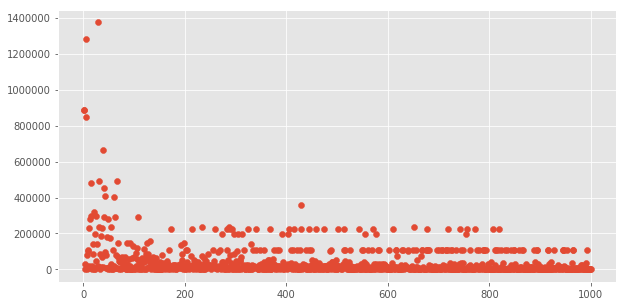

In [214]:
fan_graph = plt.scatter([i+1 for i in range(len(fans))], fans)
plt.show()

It seems that most creators of popular vlogs have under 200,000 fans. Let's remove the data point with more than 200,000 fans, and 100,000 fans to see what happens.

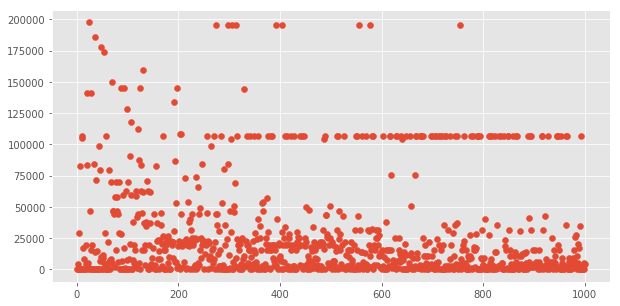

In [215]:
fans_trimmed = [i if i < 200000 else -1 for i in fans]
fan_graph_trimmed = plt.scatter([i+1 for i in range(len(fans_trimmed))], fans_trimmed)
plt.show()

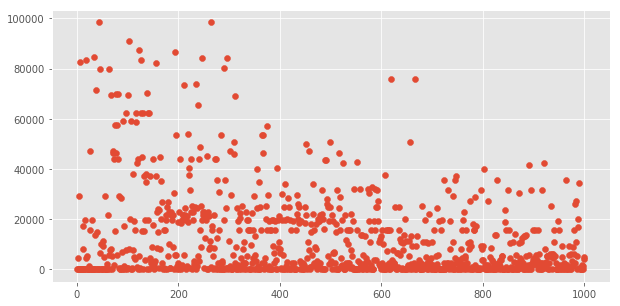

In [216]:
fans_trimmed = [i if i < 100000 else -1 for i in fans]
fan_graph_trimmed = plt.scatter([i+1 for i in range(len(fans_trimmed))], fans_trimmed)
plt.show()

Let's also divide the creators into groups based on the number of fans they have, and make a pie chart.

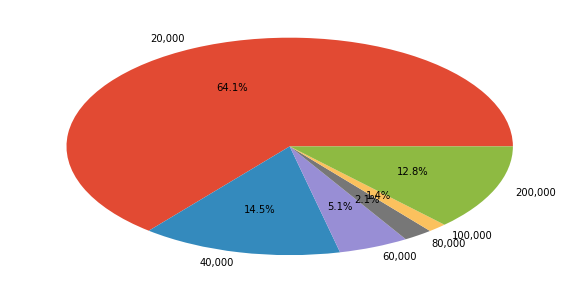

In [217]:
twenty = [i for i in fans if i <= 20000 ]
forty = [i for i in fans if i > 20000 and i <= 40000 ]
sixty = [i for i in fans if i > 40000 and i <= 60000 ]
eighty = [i for i in fans if i > 60000 and i <= 80000 ]
hundred = [i for i in fans if i > 80000 and i <= 100000 ]
twohundred = [i for i in fans if i > 100000 and i <= 200000]

fracs = [len(twenty), len(forty), len(sixty), len(eighty), len(hundred), len(twohundred)]
pie = plt.pie(fracs, labels = ['20,000', '40,000', '60,000', '80,000', '100,000', '200,000'],  autopct="%1.1f%%")
plt.show()

It seems that most creators have 20,000 or less fans. Only ~14% creators have more than 100,000 fans. 

That's it for this tutorial. I hope this brief tutorial gives you an idea of how to crawl and analyze data from websites.

#### References:
    [1] Material from 15-688 Homework 1-3
    [2] jieba https://github.com/fxsjy/jieba
    In addition, all data comes from Bilibili.com. Copyrights of all videos belong to the creators and/or Bilibili.com